In [63]:
import copy
import time
import time
import numpy as np
import argparse

from torch.utils import data

from utils.utils import *
from utils import load_config
from utils.validate import *
from fedlearning.model import *
from fedlearning.dataset import *
from fedlearning.evolve import *
from fedlearning.optimizer import GlobalUpdater, LocalUpdater, get_omegas

In [64]:
config_file = "config_fedavg_NTK.yaml"
config = load_config(config_file)

logger = init_logger(config)

model = init_model(config, logger)

record = init_record(config, model)

if config.device == "cuda":
    torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.deterministic = True

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [1]:
import copy

# Make a deep copy of the model
user_ids = np.arange(0, config.users)

# load the dataset
# dataset object is a dictionary with keys: train_data, test_data, user_with_data
# user_with_data is a dictionary with keys: userID:sampleID
# For example, in the IID setting ID's are just assigned like 0, 1, 2, 3, ...
dataset = assign_user_data(config, logger)
test_images = torch.from_numpy(dataset["test_data"]["images"]).to(config.device)
test_labels = torch.from_numpy(dataset["test_data"]["labels"]).to(config.device)

# tau candidates 
taus = np.array(config.taus)

# Create a dictionary of models for each user
model_dict = {model_id: copy.deepcopy(model) for model_id in user_ids}


NameError: name 'np' is not defined

Training a single client on their data

In [66]:
# Select user_id model
def train_on_user_data(user_id, model_dict):
    model = model_dict[user_id]

    validate_and_log(model_dict[user_id], dataset, config, record, logger)
    acc = []
    losses = []
    params_list = []

    global_kernel = None
    global_xs = None
    global_ys = None
    local_packages = []
    local_kernels = []

    # Added for memory management
    global_jac = None

    user_resource = assign_user_resource(config, user_id, 
                        dataset["train_data"], dataset["user_with_data"])
    local_updater = LocalUpdater(config, user_resource)
    # Gets the local jacobians for a given client specified in local_updater
    local_updater.local_step(model)
    # Simulate uplink transmission
    local_package = local_updater.uplink_transmit()
    local_packages.append(local_package)
    # Get local xs and ys to perform weight update
    global_xs = local_updater.xs   
    global_ys = local_updater.ys

    global_jac = combine_local_jacobians(local_packages)

    global_kernel = empirical_kernel(global_jac)

    # Returns a function that, given t and f_0, solves for f_t
    predictor = gradient_descent_ce(global_kernel.cpu(), global_ys.cpu(), config.lr)

    # This is f^(0) (X)
    with torch.no_grad():
        fx_0 = model(global_xs)


    # Configure maximum t as one more than the largest tau value
    t = torch.arange(config.taus[-1]+1)

    # Create f_x using the time values and the initial f_x
    fx_train = predictor(t, fx_0.cpu())
    # fx_train = fx_train.to(fx_0)

    # Use current weights to pass to the optimizer
    init_state_dict = copy.deepcopy(model.state_dict())

    losses = np.zeros_like(taus, dtype=float)
    acc = np.zeros_like(taus, dtype=float)

    print("loss \tacc")

    for i, tau in enumerate(config.taus):
        # initialize the weight aggregator with current weights
        weight_aggregator = WeightMod(init_state_dict)
        global_omegas = get_omegas(t[:tau+1], config.lr, global_jac, 
                global_ys.cpu(), fx_train[:tau+1], config.loss, 
                model.state_dict())
        # global_omegas = get_omegas(t[:tau+1], config.lr, global_jac, 
        #         global_ys, fx_train[:tau+1], config.loss, 
        #         model.state_dict())        
        
        # Complete the sum in 9b
        weight_aggregator.add(global_omegas)
        aggregated_weight = weight_aggregator.state_dict()
        model.load_state_dict(aggregated_weight)

        output = model(global_xs)

        loss = loss_with_output(output, global_ys, config.loss)
        # loss_fx = loss_with_output(fx_train[tau].to(global_ys), global_ys, config.loss)
        losses[i] = loss

        output = model(test_images)

        test_acc = accuracy_with_output(output, test_labels)
        acc[i] = test_acc

        print("{:.3f}\t{:.3f}".format(loss, test_acc))

        params_list.append(copy.deepcopy(aggregated_weight))

    # Get index of tau with lowest loss
    idx = np.argmin(losses)
    # Select weight parameters with lowest loss
    params = params_list[idx]

    # Select tau with lowest loss
    current_tau = taus[idx]
    current_acc = acc[idx]
    current_loss = losses[idx]

    return params

In [67]:
# Stores all new weights in an array to add together
all_updated_weights = []
num_participators = int(config.part_rate*config.users) 
participating_users = np.random.choice(user_ids, num_participators, replace=False)
for user_id in participating_users:
    all_updated_weights.append(train_on_user_data(user_id, model_dict))

Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







loss 	acc
0.369	0.363
0.308	0.374
0.281	0.374
0.266	0.371
0.258	0.371
0.252	0.369
0.249	0.369
0.247	0.367
0.245	0.366
0.244	0.365
0.245	0.362


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.250	0.359
loss 	acc
0.265	0.379
0.195	0.390
0.162	0.398
0.143	0.403
0.131	0.406
0.122	0.408
0.115	0.410
0.109	0.412
0.105	0.414
0.101	0.416
0.088	0.420


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.081	0.423
loss 	acc
0.435	0.357
0.369	0.360
0.334	0.362
0.312	0.363
0.297	0.364
0.287	0.364
0.279	0.364
0.272	0.364
0.267	0.365
0.262	0.365
0.248	0.366


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.240	0.367
loss 	acc
0.286	0.261
0.229	0.265
0.201	0.267
0.184	0.269
0.172	0.269
0.163	0.269
0.156	0.270
0.151	0.270
0.147	0.270
0.143	0.271


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.130	0.272
0.123	0.272
loss 	acc
1.003	0.147
1.140	0.142
1.236	0.140
1.305	0.138
1.359	0.136
1.405	0.135
1.444	0.134
1.477	0.133
1.506	0.133
1.531	0.132
1.623	0.131


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







1.682	0.131
loss 	acc
0.348	0.259
0.325	0.293
0.326	0.303
0.333	0.307
0.340	0.309
0.347	0.308
0.355	0.309
0.361	0.309
0.368	0.308
0.374	0.308
0.402	0.304


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.425	0.302
loss 	acc
0.130	0.220
0.099	0.227
0.085	0.230
0.077	0.232
0.072	0.233
0.068	0.233
0.065	0.233
0.062	0.233
0.061	0.233
0.059	0.234
0.054	0.234


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.051	0.235
loss 	acc
0.473	0.184
0.474	0.179
0.457	0.179
0.439	0.178
0.425	0.179
0.413	0.180
0.402	0.180
0.393	0.180
0.385	0.180
0.378	0.181


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.351	0.182
0.333	0.183
loss 	acc
0.175	0.221
0.159	0.226
0.161	0.226
0.164	0.225
0.169	0.226
0.174	0.225
0.178	0.225
0.182	0.225
0.186	0.224
0.190	0.224
0.205	0.222


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.217	0.220
loss 	acc
0.432	0.215
0.417	0.220
0.428	0.222
0.442	0.222
0.454	0.223
0.463	0.223
0.471	0.223
0.479	0.223
0.485	0.223
0.491	0.223
0.511	0.224


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.524	0.224
loss 	acc
0.003	0.100
0.001	0.100
0.001	0.100
0.001	0.100
0.001	0.100
0.000	0.100
0.000	0.100
0.000	0.100
0.000	0.100
0.000	0.100
0.000	0.100


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.000	0.100
loss 	acc
0.328	0.354
0.268	0.357
0.248	0.357
0.238	0.356
0.233	0.356
0.229	0.355
0.227	0.355
0.226	0.355
0.225	0.355
0.225	0.355
0.225	0.354


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.228	0.353
loss 	acc
0.121	0.141
0.096	0.147
0.085	0.150
0.080	0.153
0.076	0.155
0.074	0.156
0.072	0.157
0.071	0.157
0.070	0.158
0.069	0.158
0.067	0.160


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.065	0.161
loss 	acc
0.379	0.259
0.321	0.281
0.296	0.287
0.281	0.290
0.270	0.292
0.262	0.293
0.255	0.294
0.250	0.295
0.246	0.296
0.242	0.296
0.231	0.299


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.225	0.301
loss 	acc
0.250	0.272
0.209	0.275
0.189	0.276
0.177	0.278
0.168	0.278
0.162	0.279
0.157	0.279
0.154	0.280
0.150	0.280
0.147	0.280
0.138	0.281


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.132	0.281
loss 	acc
0.729	0.188
0.712	0.195
0.709	0.198
0.709	0.198
0.711	0.199
0.713	0.199
0.714	0.199
0.716	0.200
0.717	0.200
0.718	0.200
0.724	0.201


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.728	0.202
loss 	acc
0.019	0.160
0.015	0.166
0.013	0.168
0.012	0.169
0.012	0.170
0.011	0.170
0.011	0.171
0.011	0.171
0.011	0.171
0.011	0.172
0.010	0.173


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.010	0.173
loss 	acc
0.225	0.308
0.158	0.318
0.128	0.321
0.110	0.323
0.098	0.324
0.090	0.324
0.083	0.325
0.078	0.325
0.073	0.325
0.070	0.326
0.058	0.327


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.051	0.327
loss 	acc
0.804	0.219
0.755	0.222
0.730	0.227
0.712	0.229
0.697	0.231
0.685	0.232
0.677	0.234
0.670	0.235
0.664	0.236
0.660	0.238
0.646	0.241


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.641	0.244
loss 	acc
0.449	0.290
0.445	0.289
0.450	0.289
0.456	0.289
0.462	0.290
0.467	0.290
0.471	0.290
0.475	0.290
0.479	0.289
0.483	0.289
0.499	0.289


Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Test accuracy 0.0478
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135
Train loss 3.7135







0.511	0.289
loss 	acc
0.267	0.272
0.213	0.275
0.186	0.275
0.170	0.275
0.159	0.275
0.151	0.276
0.145	0.276
0.139	0.276
0.135	0.276
0.131	0.276
0.119	0.277
0.111	0.277


Histogram of test accuracies across client models

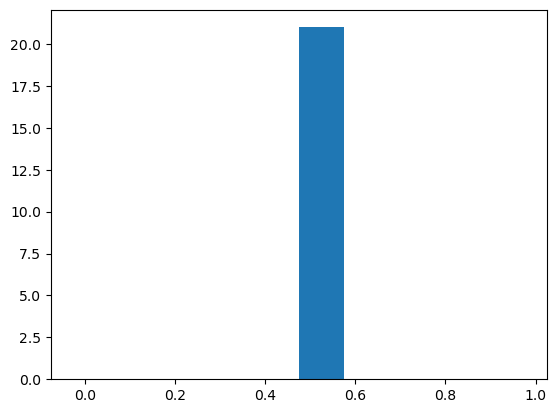

Mean test acc:  0.47450000047683716


In [106]:
individual_test_accs = [accuracy_with_output(model_dict[user_id](test_images), test_labels) for user_id in participating_users]

from matplotlib import pyplot as plt
plt.hist(individual_test_accs)
plt.show()
print("Mean test acc: ", np.mean(individual_test_accs))

In [84]:
# Grab initial weight
# Get number of data points for user 0
n_k = float(dataset["user_with_data"][0].size)
# get total number of data points for the round
n = float(np.sum([dataset["user_with_data"][user_id].size for user_id in participating_users]))
# Perform first weighted sum
weight_aggregator = WeightMod(all_updated_weights[0])
weight_aggregator.mul(n_k)
# Add all weights together in weighted sum
for i in range(1, len(all_updated_weights)):
    wi = WeightMod(all_updated_weights[i])
    n_k = float(dataset["user_with_data"][i].size)
    # Weight the weight by # of datapoints
    wi.mul(n_k)
    weight_aggregator.add(wi)

# Scale by number of data points
weight_aggregator.mul(1.0/n)

In [104]:
# Load weights into new model to test performance
new_agg_weights = weight_aggregator.state_dict()
model = init_model(config, logger)
model.load_state_dict(new_agg_weights)
output = model(test_images)
final_acc = accuracy_with_output(output, test_labels)
print("Final acc: ", final_acc)

Final acc:  0.47450000047683716


Now that one round is over, need to load the weights into all other models

In [105]:
for user_id in user_ids:
    model_dict[user_id].load_state_dict(new_agg_weights)